# Example: Generate and Visualize Calorimeter Showers

This notebook shows how to:
1. Load a trained VAE model
2. Generate synthetic showers
3. Visualize and compare to real data

# Imports

In [6]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py

from calogan_vae.models import build_vae_from_config
from calogan_vae.data import get_preprocessor

# Load trained model

In [7]:
checkpoint = torch.load('../checkpoints/fix_generation/best_model.pth')
config = checkpoint['config']

model = build_vae_from_config(config.encoder, config.decoder)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch']}")

Loaded model from epoch 50


C:\Users\erlin\AppData\Local\Temp\ipykernel_29996\1348881178.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../checkpoints/fix_generation/best_

# Setup preprocessor

In [8]:
preprocessor = get_preprocessor('log1p_norm', percentile=99.0)

# Fit on sample data (in practice, load from training data)
# ... fit preprocessor ...

# Generate samples

In [14]:
from calogan_vae.data import CaloDataset, get_preprocessor
from torch.utils.data import DataLoader

In [15]:
# Load a small batch of data to fit the preprocessor
print("Fitting preprocessor...")
dataset = CaloDataset(
    h5_path='../eplus.hdf5',  # Assumes dataset is in the parent directory
    layer_keys=['layer_0', 'layer_1', 'layer_2'],
    max_events=1000,          # fit on 1000 samples
    loading_mode='memory',
    preprocessor=None
)
# Get data as numpy array
loader = DataLoader(dataset, batch_size=1000, shuffle=False)
sample_data = next(iter(loader)).numpy()
# Fit
preprocessor.fit(sample_data)
print("Preprocessor fitted successfully!")

Fitting preprocessor...
Preprocessor fitted successfully!


# Visualize

In [17]:
# Create a NEW cell for this:
num_samples = 100
z = torch.randn(num_samples, model.z_dim)

with torch.no_grad():
    generated_preprocessed = model.decode(z).numpy()

# Convert to original scale
generated = preprocessor.inverse(generated_preprocessed)

print(f"Generated {num_samples} samples")
print(f"Shape: {generated.shape}")
print(f"Energy range: [{generated.sum(axis=(1,2,3)).min():.1f}, {generated.sum(axis=(1,2,3)).max():.1f}]")

[DEBUG] Input to inverse:
  Mean: 0.034776
  Std: 0.064878
  Min: 0.000000
  Max: 0.398465
[DEBUG] After denormalization:
  Mean: 0.303380
  scale_factor: 8.723908
[DEBUG] After expm1:
  Mean: 0.666320
Generated 100 samples
Shape: (100, 3, 12, 96)
Energy range: [1897.1, 3068.2]


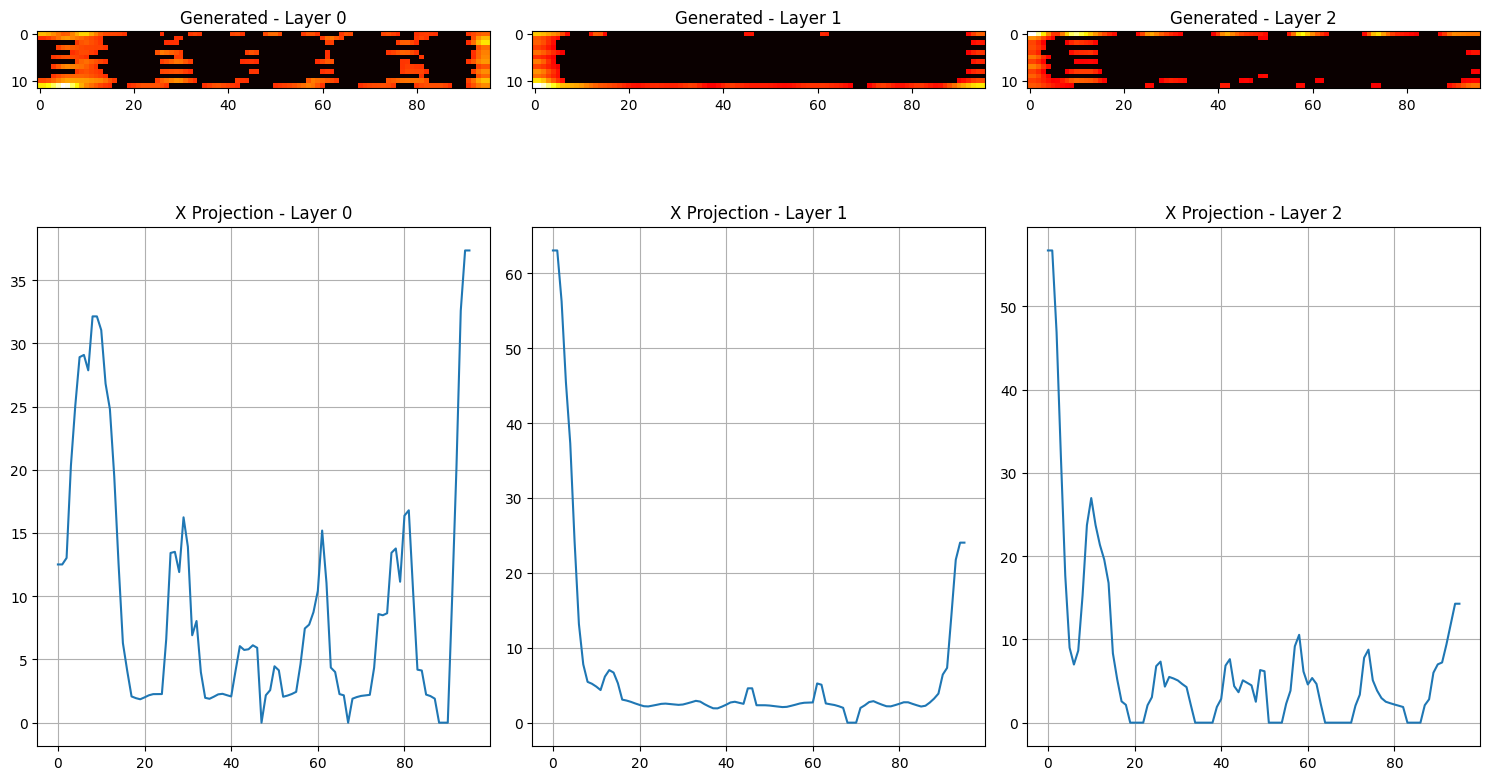

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    # Layer i
    axes[0, i].imshow(np.log1p(generated[0, i]), cmap='hot')
    axes[0, i].set_title(f'Generated - Layer {i}')
    
    axes[1, i].plot(generated[0, i].sum(axis=0))
    axes[1, i].set_title(f'X Projection - Layer {i}')
    axes[1, i].grid(True)

plt.tight_layout()
plt.savefig('generated_example.png')
plt.show()


# Save generated data

In [ ]:
with h5py.File('my_generated_showers.h5', 'w') as f:
    f.create_dataset('showers', data=generated)
    f.attrs['num_samples'] = num_samples
    f.attrs['model_checkpoint'] = '../checkpoints/fix_generation/best_model.pth'

print("Saved to my_generated_showers.h5")

Saved to my_generated_showers.h5


# interactively 

## Load model

In [21]:
checkpoint = torch.load('../checkpoints/fix_generation/best_model.pth')
model = build_vae_from_config(config.encoder, config.decoder)
# ... see the model structure ...

C:\Users\erlin\AppData\Local\Temp\ipykernel_29996\2857378780.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../checkpoints/fix_generation/best_

## Generate samples

In [22]:
z = torch.randn(100, 64)
generated = model.decode(z)
# ... see generated data stats ..

## Plot immediately

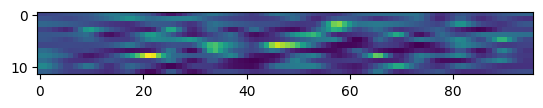

In [24]:
# Use .detach().cpu().numpy() to convert the tensor to a displayable array
plt.imshow(generated[0, 0].detach().cpu().numpy()) 
plt.show()